# Classification Metrics and Logistic Regression Practice

Let's start off with a page from [Google's Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative) and talk about a classic classification problem:

### The Boy Who Cried 'Wolf'

![adorable wolf image from instagram user fablefire: https://www.instagram.com/p/CCGgVLGFneE/](images/awoo.png)

In the old fable about the boy who cried 'wolf' there are two possible outcomes: 

- **No Wolf** - negative outcome, or 0
- **Wolf** - positive outcome, or 1

(I know, having a wolf arrive is not "positive" - but it is what we're trying to predict)

If you think of this as a model, where the shepherd is predicting whether or not a wolf will threaten the flock of sheep:

![outcome description for wolf scenarios as a confusion matrix](images/wolf_confusion_matrix.png)

So what does that look like with data?

In [1]:
# All of the imports

import pandas as pd
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix # New to version 0.22.2

In [2]:
df = pd.read_csv('data/titanic.csv', index_col = "PassengerId")

In [3]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Model-less Baseline

First of all, I want to see how well the model will do if it predicts the majority class. In other words, if the model only predicts that no one survives, what percentage of the time would it be right? 

How do we do this? Find the number of passengers who didn't survive, divide by the total number of passengers.

In [4]:
num_passengers = len(df)

In [5]:
num_passenger_didnotsurvive = len(df.loc[df['Survived'] == 0])

In [6]:
# Find percent who did not survive
num_passenger_didnotsurvive / num_passengers

0.6161616161616161

In [ ]:
# Another way to do this - the mean of this column gives the percentage of
# passengers who DID survive because it's a 0/1 binary - find the inverse


To visualize:

In [7]:
y_actual = df['Survived']

In [8]:
y_pred_baseline = [0] * num_passengers

In [9]:
# A confusion matrix
confusion_matrix(y_actual, y_pred_baseline)

array([[549,   0],
       [342,   0]], dtype=int64)

Or, prettier: 

<img alt="table view with colors to show results of modelless baseline" src="images/titanic_modelless_baseline_cm.png" height=200 width=200>

## Confusion Matrix &rarr; Classification Metrics

That block above, where we hashed out true negatives / true positives / false negatives / false positives, is called a **Confusion Matrix** - a summary of how well a classification model was able to predict each class. Across one axis you have the _predicted_ labels, and across the other axis you have the _actual_ labels, and thus you're able to clearly see the breakdown of where a model is making mistakes - and, more importantly, what kinds of mistakes your model is making.

So - how does a confusion matrix translate into classification metrics?

### Confusion Matrix Interpretation


<img alt="confusion matrix interpretation with metrics" src="images/confusion_matrix_interpretation.png" height=600 width=600>

Note that I've highlighted the most often used metrics in blue above. 

In other words, those metrics are:

- Accuracy: All True Predictions / All Predictions

- Precision score: TP / All Predicted Positives

- Recall or Sensitivity: TP / All Actual Positives 

There's one more score that's often referenced which balances precision and recall - it's called an [**F1 Score**](https://en.wikipedia.org/wiki/F1_score).

$$ \text{F1 Score} = 2 * \frac{ precision * recall}{precision + recall} $$


**Let's Discuss**: Why might we care more about precision than recall, or vice versa?

- 


----

Moving on - luckily SKLearn will of course calculate these scores for us. You can see all of their classification metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

## Logistic Regression

![monty python, 'nobody expects the logistic regression](images/nobodyexpectslogreg.jpg)

In general, I'll be following the imputation/scaling strategy outlined [here](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html) (just in a more laid-out way)

In [21]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isMale
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


I want to use the columns: `Age`, `Fare`, `Sex`, and `Pclass` - a combination of types, also `Age` has null values.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
 11  isMale    891 non-null    uint8  
dtypes: float64(2), int64(4), object(5), uint8(1)
memory usage: 84.4+ KB


In [23]:
# First, let's encode our categorical column, Sex

enc_sex = pd.get_dummies(df['Sex'], drop_first=True)

# Add the column
df['isMale'] = enc_sex

In [24]:
# Defining my X and y

X = df[['Pclass', 'isMale', 'Age', 'Fare']]
y = df['Survived']

In [25]:
# And then doing a train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [26]:
# For Age, I need to impute nulls
age_imputer = SimpleImputer(strategy='median')
X_train_nonulls = age_imputer.fit_transform(X_train)
X_test_nonulls = age_imputer.transform(X_test)

In [27]:
# Now, let's scale our data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_nonulls)
X_test_scaled = scaler.transform(X_test_nonulls)

In [28]:
# Instantiate our model
logreg = LogisticRegression()

In [32]:
# Now, fitting our model and grabbing our training and testing predictions
logreg.fit(X_train_scaled, y_train)

train_preds = logreg.predict(X_train_scaled)
test_preds = logreg.predict(X_test_scaled)

In [38]:
 len(X_test_scaled)

179

In [33]:
confusion_matrix(y_test, test_preds)

array([[89, 16],
       [21, 53]], dtype=int64)

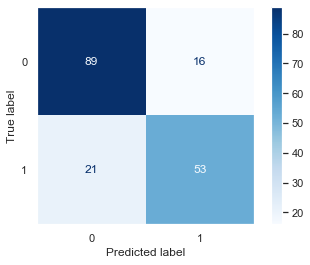

In [34]:
# Plotting the confusion matrix using SKLearn
plot_confusion_matrix(logreg, X_test_scaled, y_test,
                      cmap=plt.cm.Blues, # Changing the color scheme
                      values_format=".3g") # Formatting the numbers properly
plt.grid(False) # This just removes an annoying grid that shows up by default

plt.show()

In [36]:
# Printing the metrics nicely
metrics = {"Accuracy": accuracy_score,
           "Recall": recall_score,
           "Precision": precision_score,
           "F1-Score": f1_score}

for name, metric in metrics.items():
    print(f"{name}:"); print("="*len(name))
    print(f"TRAIN: {metric(y_train, train_preds):.4f}")
    print(f"TEST: {metric(y_test, test_preds):.4f}")
    print("*" * 15)

Accuracy:
TRAIN: 0.7879
TEST: 0.7933
***************
Recall:
TRAIN: 0.6903
TEST: 0.7162
***************
Precision:
TRAIN: 0.7312
TEST: 0.7681
***************
F1-Score:
TRAIN: 0.7102
TEST: 0.7413
***************


### Evaluation:

So, how'd we do? Specifically, how'd we do compared to our model-less baseline?

- 


### Next Steps

What can we potentially do to improve this model?

- 


## Neat Tricks

Let's try the code directly from the link above, which uses some neat tricks:

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['Sex', 'Pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Survived'), y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

In [ ]:
# Plotting the confusion matrix using SKLearn
plot_confusion_matrix(clf, X_test, y_test,
                      cmap=plt.cm.Blues, # Changing the color scheme
                      values_format=".3g") # Formatting the numbers properly
plt.grid(False) # This just removes an annoying grid that shows up by default

plt.show()

In [ ]:
for name, metric in metrics.items():
    print(f"{name}:"); print("="*len(name))
    print(f"TRAIN: {metric(y_train, y_train_pred):.4f}")
    print(f"TEST: {metric(y_test, y_test_pred):.4f}")
    print("*" * 15)